## Dimensionality Reduction: Based on feature properties
why reduce dimentionality:
- ML algorithm has lower change to overfit
- reduce complexity and let computational effort.

Remember to **avoid overfitting** the number of observation should increase **exponentially** with the number of feature!!! <br>

In [85]:
import os
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib   import Path
from IPython.display import Image
from sklearn.feature_selection import VarianceThreshold

In [96]:
# set root directory
path_root = Path("C:/Users/giann/data-science-core")
os.chdir(path_root)
print(f'- Root directory = {os.getcwd()}')

- Root directory = C:\Users\giann\data-science-core


In [134]:
# import dataset
path_dataset = path_root / 'dataset/pokemon.csv'
data  = pd.read_csv(path_dataset)
data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


### Remove feature with low variance

In [18]:
data.var()

#             43407.137983
Total         14391.130907
HP              652.019323
Attack         1053.480599
Defense         972.410707
Sp. Atk        1070.748536
Sp. Def         774.448554
Speed           844.511133
Generation        2.759886
Legendary         0.074742
dtype: float64

In [131]:
data.describe(exclude = 'number')

,Name,Type 1,Type 2,Legendary
count,800,800,414,800
unique,800,18,18,2
top,Hoothoot,Water,Flying,False
freq,1,112,97,735


In [138]:
data['Legendary'].value_counts() / len(data['Legendary'])

False    0.91875
True     0.08125
Name: Legendary, dtype: float64

`Legendary` feature could be removed since it is primarily all `False`. On the other hand, be carefult to `Name` which has a huge variance.

In [20]:
_ = data.drop(labels = ['Legendary'], inplace = True, axis = 1)

### Removing features with many missing values

In [99]:
print(data.isna().sum() / len(data))

#             0.0000
Name          0.0000
Type 1        0.0000
Type 2        0.4825
Total         0.0000
HP            0.0000
Attack        0.0000
Defense       0.0000
Sp. Atk       0.0000
Sp. Def       0.0000
Speed         0.0000
Generation    0.0000
Legendary     0.0000
dtype: float64


`type 2` has 48% of missing value.

In [102]:
# Create a boolean mask on whether each feature less than 40% missing values.
mask = data.isna().sum() / len(data) < 0.4
# Create a reduced dataset by applying the mask
reduced_df = data.loc[:, mask]
print("Dimensionality reduced from {} to {}.".format(data.shape[1], reduced_df.shape[1]))

Dimensionality reduced from 13 to 12.


### Remove feature with high correlation
- If feature are highly correlated, e.g. +-1, then one has to remove one of the two features. <br>
- always check if removing highly correlated features with **domain knowledge**. If feature measure similar things then we can discard one of them.
- non-linear dependency and outliers can produce weird correlation value, e.g., **Anscombe's quartet**. Hence, before remove it you need to visually inspect.
- Strong correlation **do not imply** causation

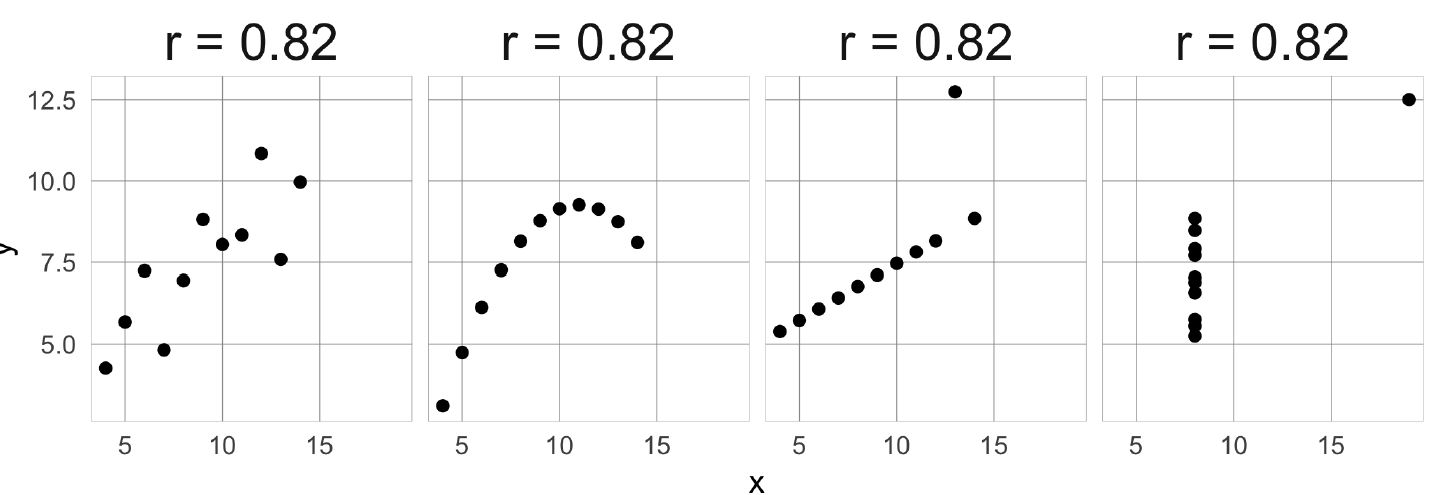

In [115]:
# r is the correlation
Image(filename = 'plot/Anscombe quartet.png', width = 500, height = 250)

In [117]:
# import dataset
path_dataset = path_root / 'dataset/ANSUR_II_FEMALE.csv'
data  = pd.read_csv(path_dataset)
data = data.iloc[:, 10:20] 
data.head()

,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,bideltoidbreadth,bimalleolarbreadth,bitragionchinarc,bitragionsubmandibulararc,bizygomaticbreadth,buttockcircumference,buttockdepth
0,373,315,263,466,65,338,301,141,1011,223
1,372,272,250,430,64,294,270,126,893,186
2,397,300,276,450,69,309,270,128,987,204
3,384,364,276,484,68,340,294,144,1012,253
4,378,320,336,525,67,300,295,135,1281,284


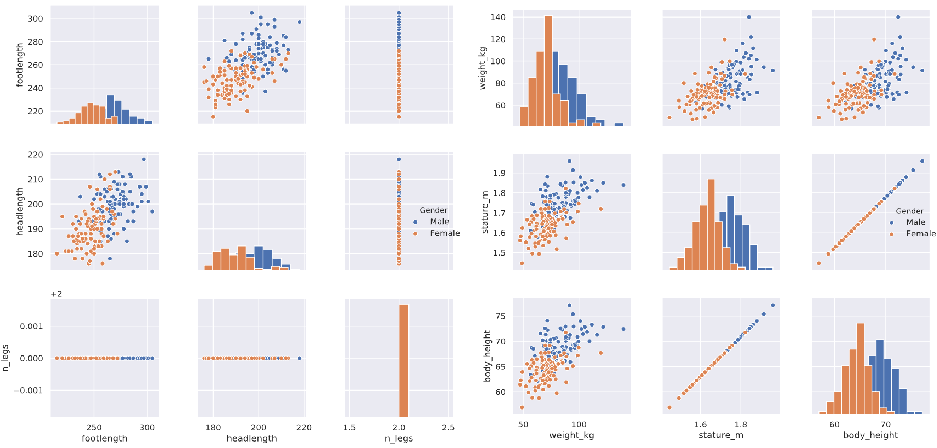

In [32]:
# Visually inspect high correlation
Image(filename = 'plot/dim_reduction_plot.png')

In this case remove features `n_legs` and either `stature_m` or `body_height`.

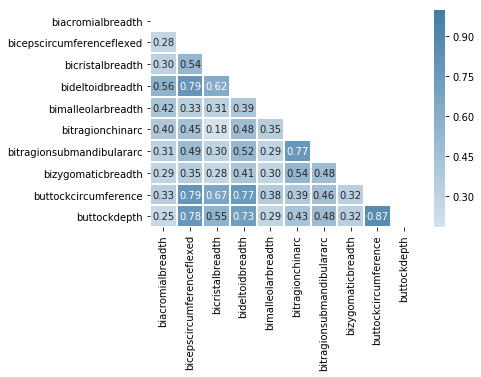

In [116]:
# Create the correlation matrix
corr = data.corr()
# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(corr, dtype=bool))
# Add the mask to the heatmap
cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

Here we see almost 90% correlation between `buttockcircumference` and `buttockdepth`. One of the two features could be discarded in order to avoid overfitting.

#### Automatic remove high colleration features
Calculate the correlation matrix and filter out columns that have a correlation coefficient of more than 0.95 or less than -0.95.

In [121]:
# Calculate the correlation matrix and take the absolute value
corr_matrix = data.corr().abs()
# Create a True/False mask and apply it
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)
# List column names of highly correlated features (r > 0.95)
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.80)]
# Drop the features in the to_drop list
reduced_df = data.drop(to_drop, axis=1)
print("Dimensionality reduced from {} to {}.".format(data.shape[1], reduced_df.shape[1]))

Dimensionality reduced from 10 to 9.


### Discard features with little variance
- Create a selector with specific minimum variance threshold. Note that first you need to **normalize** the dataset.

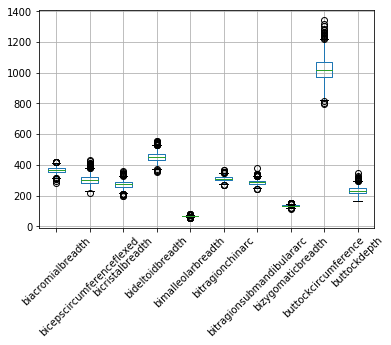

In [110]:
# before normalization
data.boxplot(rot = 45)
plt.show()

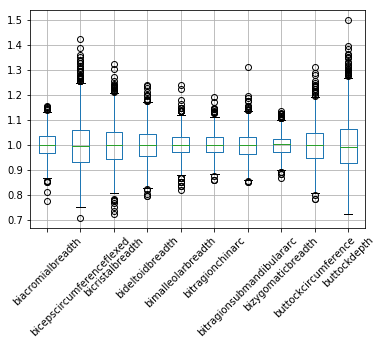

In [83]:
# after normalization
normalized_df = data / data.mean()
normalized_df.boxplot(rot = 45)
plt.show()

In [84]:
# Print the variances of the normalized data
print(normalized_df.var())

biacromialbreadth            0.002509
bicepscircumferenceflexed    0.010131
bicristalbreadth             0.006634
bideltoidbreadth             0.004058
bimalleolarbreadth           0.002703
bitragionchinarc             0.002073
bitragionsubmandibulararc    0.002822
bizygomaticbreadth           0.001730
buttockcircumference         0.005523
buttockdepth                 0.010909
dtype: float64


Inspect the printed variances and decide which **variance threshold** could be suitable, in this case we set `threshold = 0.005`

In [93]:
# Create a VarianceThreshold feature selector
sel = VarianceThreshold(threshold = 0.005) # default was 0.001
# Fit the selector to normalized head_df
sel.fit(data / data.mean())
# Create a boolean mask
mask = sel.get_support()
# Apply the mask to create a reduced dataframe
reduced_df = data.loc[:, mask]
print("Dimensionality reduced from {} to {}.".format(data.shape[1], reduced_df.shape[1]))

Dimensionality reduced from 10 to 4.
